In [96]:
import argparse
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import torchvision

import snntorch as snn
from snntorch import surrogate
from snntorch import backprop
import snntorch.functional as SF

import scipy.sparse as sp
import scipy.sparse.linalg
import time


# parser = argparse.ArgumentParser()
# parser.add_argument('--batch_size', type=int, help="train and eval batch size")
# parser.add_argument('--n_epochs', type=int, help="number of training epochs")
# parser.add_argument('--eta', type=float, help="initial learning rate")

# args = parser.parse_args()


import sortednp
import scipy.sparse as sp
import scipy.sparse.linalg
from scipy.special import log_softmax
from scipy.special import softmax
from numpy_ml.neural_nets.optimizers import Adam, SGD
from numpy_ml.neural_nets.schedulers import ExponentialScheduler

# Define neuron behavior for SNN

proj = False

print('proj', proj)

class LIFNeuron(object):
    
    def __init__(
        self,
        in_dim,
        beta,  # inverse membrane time constant
        alpha=0.0,  # inverse synaptic time constant
        threshold=1.0,
        weight=None,
        layer_idx=0,
        neuron_idx=0,
    ):
        super().__init__()
        self.in_dim = in_dim
        self.beta = beta
        self.alpha = alpha
        self.threshold = threshold
        if weight is None:
            self.weight = np.random.randn(self.in_dim)  # change later, other initializers
        
        self.layer_idx = layer_idx
        self.neuron_idx = neuron_idx
        
    
    def forward(self, inputs, T, weight=None):
        """
        x - input firing times 
        T - maximum time horizon
        """
        if weight is None:
            w = self.weight
        else:
            w = weight
            
        if type(inputs) is np.ndarray and len(inputs.shape) < 2:
            inputs = np.expand_dims(inputs, axis=0)
            
        if type(w) is not list and type(w) is not np.ndarray:
            w = [w]
        
        return self._evolve(
            T,
            inputs,
            w,
            alpha=self.alpha,
            beta=self.beta,
            theta=self.threshold
        )
    
    
    # function for estimating the firing time
    def _evolve(self, t_max, spikes, w, A=0, B=0, alpha=2, beta=1, theta=1):
        
        # check the validity of alpha and beta
        if alpha==beta:
            raise ValueError('There might be some numerical instability for equal alpha and beta.')
            
        # check that inputs are sorted... or sort them
        spikes = [spikes[i] if np.all(spikes[i][:-1] <= spikes[i][1:]) else np.sort(spikes[i]) \
                  for i in range(len(spikes))]

        # number of neurons
        N=len(spikes)

        # produce the corresponding weights
        w_mat=[]
        idx=[]
        for i, el in enumerate(w):
            leni=len(spikes[i])
            w_mat.append(np.array([w[i]]*leni))
            idx.append(np.array([i]*leni))
        
        spk=None
        wt=None
        neuron=None
        for i in range(N):
            if spikes[i].size > 0:
                if spk is None:
                    spk=spikes[i]
                    wt=w_mat[i]
                    neuron=idx[i]
                else:
                    spk=np.concatenate((spk, spikes[i]))
                    wt=np.concatenate((wt, w_mat[i]))
                    neuron=np.concatenate((neuron, idx[i]))
                    
        # inputs are all empty...
        if spk is None:
            return np.array([]), w, {}, {}

        # sort the firing time and keep the same order for weights
        order=np.argsort(spk)
    
        spk=spk[order]
        wt=wt[order]
        neuron=neuron[order]

        # reference time and next firing time
        start=0

        fire_max=t_max
        fire=fire_max

        # list to save firing time
        fire_time=[]

        # define the iterator
        spk_iter=iter(zip(spk,wt,neuron))

        # Create causal edges
        M_f = {}
        queue = []
        
        while (fwn:=next(spk_iter,None)) is not None:
            # read the weight and firing time of the next spike
            f,w,n=fwn

            # check to see if the firing time "f" is larger than the next predicted 
            # firing time
            if f>fire:
                # fire is valid firing time because it happens before "f"

                # (1) save this firing time as valid one
                fire_time.append(fire)
                
                # Update causal diagram
                M_f[fire] = queue.copy()

                # (2) update the potentials due to firing
                A=A*np.exp(-alpha*(fire-start))
                B=B*np.exp(-beta*(fire-start))-theta # the effect of membrane reset

                # (3) change the start to the latest firing time
                start=fire

                #print("potential at the firing time=", A, B, A+B)

                # (4) tricky part:
                # it may happen that even after potential reset, the neuron has several
                # new firings even before it receives a new spike from its neigboring neurons
                # we should add all these firing time

                while True:
                    # a simple sufficient condition
                    # if the derivative is negative no new firing can happen
                    if -(A*alpha+B*beta)<0:
                        fire=fire_max+1
                        break

                    # otherwise find the next root starting from the reference
                    fire_rel=self._solve(A,alpha,B,beta,theta)

                    # take into account the effect of reference point

                    if fire_rel==None or fire_rel+start>f:
                        fire=fire_max+1
                        break

                    # otherwise the firing time is a valid one
                    # (1) save the firing time
                    # take the reference into account
                    fire=fire_rel+start

                    fire_time.append(fire)
                    M_f[fire] = queue.copy()

                    # (2) update the potentials due to firing
                    A=A*np.exp(-alpha*(fire_rel))
                    B=B*np.exp(-beta*(fire_rel))-theta # the effect of membrane reset

                    #print("potential at the firing time=", A, B, A+B)

                    # (3) change the start to the latest firing time
                    start=fire

                    # (4) continue this procedure to register all in-between firing times
                
                # empty the queue
                # queue = []
                    
            queue.append((f,n))

            # now there are no residula firing times from past
            # the new input spike should be processed

            # update A and B until the current firing time "f"
            A=A*np.exp(-alpha*(f-start))
            B=B*np.exp(-beta*(f-start))

            # add the effect of new spike
            A+=w/(beta-alpha)
            B+=w/(alpha-beta)


            # also adjust the reference time
            start=f

            # find the firing time for the updated kernel
            fire_rel=self._solve(A, alpha, B, beta, theta)

            # if there is no firing time: set fire to infinity (here fire_max+1)
            if fire_rel==None:
                fire=fire_max+1
                #print("No firing time in this interval")
            else:
                # adjust the firing time with respect to the reference point
                fire=fire_rel+start
                #print("speculated firing time: ", fire)

        # at this stage all input spikes are processed but the neuron
        # may keep producing spikes due to its residual potential
        # we need to add also those firing times

        while fire<fire_max:
            # still some residual firing left

            # add fire to the list
            fire_time.append(fire)
            M_f[fire] = queue.copy()
            

            # adjust the parameters
            A=A*np.exp(-alpha*(fire-start))
            B=B*np.exp(-beta*(fire-start))-theta

            # adjust the reference time
            start=fire

            # a simple sufficient condition
            # if the derivative is negative no new firing can happen
            if -(A*alpha+B*beta)<0:
                fire=fire_max+1
                break

            # otherwise find the next root starting from the reference
            fire_rel=self._solve(A,alpha,B,beta,theta)

            # take into account the effect of reference point and decide
            if fire_rel==None or fire_rel+start>fire_max:
                fire=fire_max+1
                break
            else:
                # adjust the firing time with respect to the refernce
                # repeat the loop
                fire=fire_rel+start
                
        # return the produced spikes (and other info)
        fire_time=np.asarray(fire_time)
        M_n={}  # layer_idx/neuron_idx - list<firing time, neuron>
        
        if fire_time.size < 1:
            M_n[(self.layer_idx, self.neuron_idx)]=np.array([])    
        else:
            M_n[(self.layer_idx, self.neuron_idx)] = fire_time
        
        return fire_time, w, M_f, M_n
    
    
    def _solve(self, A, alpha, B, beta, theta, rel_err=0.0000001):
        """
        A, alpha: weights corresponding to the synapse
        B, beta: weights corresponding to the membrane
        theta: the firing threshold

        aim: solve
            A exp(-alpha t) + B exp(-beta t) = theta
        """

        #============= find the value and the derivative of function at t=0 =======
        # value of the function at t=0
        val_0= A+B

        # derivative of the function at t=0
        der_0=-alpha*A-beta*B


        #=========== find the extremum point in [0, infty]==========
    
        #----------- compute the extremum point parameter --------
        # if this parameter is negative the function is monotone
        par_ext=-(beta*B)/(alpha*A)

        # compute the extremeum point 
        if par_ext<0:
            t_ext=0
        else:
            if alpha!=beta:
                t_ext= np.maximum(np.log(par_ext)/(beta-alpha), 0.)
            else:
                # use l'Hopital rule
                t_ext=np.log(-B/A)*(1/alpha)

        # the extremum value
        val_ext=A*np.exp(-alpha*t_ext) + B*np.exp(-beta*t_ext)


        #================ decide based on the info ========
        if val_0>theta and val_ext>theta:
            # the function is increasing at first and starts above theta
            t_min=t_ext
            t_max=np.inf
        elif val_0>theta and val_ext<theta:
            # the function has a minimum
            t_min=0
            t_max=t_ext
        elif val_0<theta and val_ext>theta:
            # the function is increasing at first and has a maximum
            t_min=0
            t_max=t_ext
        elif val_0<theta and val_ext<theta:
            # the function starts below theta and is decreasing at first
            # it cannot intersect theta
            return None
        else:
            print("val_0=", val_0)
            print("val_ext=", val_ext)
            return None

        #================= refine the search interval ==================

        #------------ first: solve the problem of t_max in case it is None -------
        if t_max==np.inf:
            ab=alpha if alpha<beta else beta
            t_max=1/ab
            scale=2
            while True:
                # evaluate the function
                val_max=A*np.exp(-alpha*t_max) + B*np.exp(-beta*t_max)
                if val_max < theta:
                    break

                # if not yet below the threshold theta: scale t_max
                t_max=scale*t_max

        #------------ Now t_min and t_max are known:=> refine the interval --------
        val_min=A*np.exp(-alpha*t_min)+B*np.exp(-beta*t_min)
        val_max=A*np.exp(-alpha*t_max)+B*np.exp(-beta*t_max)

        while True:
            # find the point in the middle
            t_mid=(t_min + t_max)/2
            val_mid=A*np.exp(-alpha*t_mid)+B*np.exp(-beta*t_mid)

            # check the condition
            if (val_mid>theta and val_max>=theta) or (val_mid<theta and val_max<theta):
                t_max=t_mid
            else:
                t_min=t_mid

            # compute the precision
            dt=t_max-t_min
            t_avg=(t_max+t_min)/2
            if dt/t_avg < rel_err:
                break

        return t_avg
    

    
class FeedForwardSNN(object):
    
    def __init__(
        self,
        in_dim,
        beta,  # inverse membrane time constant
        alpha=0.0,  # inverse synaptic time constant
        threshold=1.0,
        layer_sizes=None,
        weights=None
    ):  
        super().__init__()
        self.in_dim = in_dim
        self.beta = beta
        self.alpha = alpha
        self.threshold = threshold
        
        if not layer_sizes:
            self.layer_sizes = [input_size]
        else:
            self.layer_sizes = layer_sizes
        
        self.layer = [[] for sz in range(len(self.layer_sizes))]
        self.weights = weights  # change this later, proper initializer
        
        
    def build(self):  # don't need this explicitly if using torch
        for i, sz in enumerate(self.layer_sizes):
            for j in range(sz):
                self.layer[i].append(
                    LIFNeuron(
                        self.in_dim if i == 0 else self.layer_sizes[i-1], 
                        self.beta, 
                        alpha=self.alpha,
                        threshold=self.threshold,
                        weight=None if self.weights is None else self.weights[i][j],
                        layer_idx=i,
                        neuron_idx=j
                    )
                )        
        return self
    
    
    def forward(self, inputs, T, weights=None):
        if not weights:
            assert self.weights is not None
            weights = self.weights
            
        ret=[[] for i in range(len(self.weights))]
        
        r_o = [np.zeros(len(w)) for w in self.weights]
        
        M_f={}
        M_n={}
        
        if type(inputs) is list:
            inputs = np.asarray(inputs)
        
        prev_out=inputs
        
        for i, layer in enumerate(self.layer):
            curr_out = []
            for j, neuron in enumerate(layer):
                out, w, out_f, out_n = neuron.forward(inputs=prev_out, T=T, weight=weights[i][j])
                r_o[i][j] = np.size(out)/T
                M_f={**M_f, **out_f}
                M_n={**M_n, **out_n}
                curr_out.append(out)
            ret[i] = curr_out
            prev_out = curr_out

        return inputs, ret, weights, M_f, M_n, r_o
    
    
    def update(self, new_weights, T, r_os=None, zeta_0=-np.inf):
        
        # Project weights onto affine space to keep SNN firing
        if proj:
            for r_o in r_os:
                _, idxs = self._calculate_zeta(r_o, new_weights, T, zeta_0)
                new_weights = self._project_w(r_o, new_weights, T, idxs, zeta_0)
            
        self.weights = new_weights
        
    
    def _calculate_zeta(self, r_o, weights, T, zeta_0=-np.inf):
        alpha=self.alpha
        beta=self.beta
        theta=self.threshold
        in_dim=self.in_dim

        zeta = [np.zeros_like(r) for r in r_o]
        idxs = []

        for layer in range(len(weights)):
            for neuron, w in enumerate(weights[layer]):
                r_i = np.ones_like(w)/T if layer == 0 else r_o[layer - 1]
                wra = np.dot(w, r_i)/alpha
                rth = r_o[layer][neuron] * theta
                z = (wra - rth)/(beta * theta)
                if z < zeta_0:
                    idxs.append((layer, neuron))
                zeta[layer][neuron] = z
        return zeta, idxs
    
    
    def _project_w(self, r_o, weights, T, idx, zeta_0):
        alpha=self.alpha
        beta=self.beta
        theta=self.threshold
        in_dim=self.in_dim

        proj = [np.copy(w) for w in weights]
        for layer in range(len(weights)):
            for neuron, w in enumerate(weights[layer]):
                if (layer, neuron) not in idx:
                    continue
                else:
                    ra = np.ones_like(w)/T if layer == 0 else r_o[layer - 1]
                    ra = ra/alpha
                    wra = np.dot(w, ra)
                    th = theta * (r_o[layer][neuron] + zeta_0 * beta)
                    N = np.dot(ra, ra)

                    num = (wra - th)/N
                    proj[layer][neuron] = w - np.multiply(num, ra)
        return proj
        
        
        
class SNNUtil:
    
    @staticmethod
    def V_w(fs, prev, alpha, beta, theta):
        v_w=(np.exp(-alpha*(fs-prev))-np.exp(-beta*(fs-prev)))/(beta-alpha)*np.heaviside(fs-prev,0)
        return v_w

    @staticmethod
    def V_fs(fs, prev, w, alpha, beta, theta):
        v_fs=w*(-alpha*np.exp(-alpha*(fs-prev))+beta*np.exp(-beta*(fs-prev)))/(beta-alpha)*np.heaviside(fs-prev,0)
        return v_fs

    @staticmethod
    def V_fp(fs, prev, w, alpha, beta, theta):
        v_fp=w*(alpha*np.exp(-alpha*(fs-prev))-beta*np.exp(-beta*(fs-prev)))/(beta-alpha)*np.heaviside(fs-prev,0)
        return v_fp
    

    
class SnnCrossEntropy(object):
    
    def __init__(
        self,
        num_classes,
        T,
        alpha,
        beta,
        theta,
        tau_0,
        tau_1,
        gamma,
    ):
        self.num_classes = num_classes
        self.T = T
        self.alpha = alpha
        self.beta = beta
        self.theta = theta
        self.tau_0 = tau_0
        self.tau_1 = tau_1
        self.gamma = gamma
        
        
    def _first_spikes(self, outputs):
        assert len(outputs) == self.num_classes
        return np.asarray([np.min(outputs[i], initial=self.T) for i in range(len(outputs))])
    
    
    def forward(
        self, 
        outputs,
        label, 
    ):
        # outputs is a list of np.array containing firing times
        # label is a number in [K] where K is number of classes
        
        first_spks = self._first_spikes(outputs)
        reg_term = np.exp(first_spks[label] / self.tau_1) - 1
        return -(log_softmax(-first_spks / self.tau_0)[label] + self.gamma * reg_term)

    
    def backward(
        self,
        inputs,
        outputs,
        weights,
        label,
        M_f=None,
        M_n=None,
    ):
        
        # truncate because only first firing time matters
        first_spks = self._first_spikes(outputs[-1])
        max_f = np.max(first_spks)
        
        # TODO need to update weight.grad in torch framework
        
        all_fire=None
        f_to_n={}
        f_to_idx={}
        for layer in range(len(outputs)):
            for j, out in enumerate(outputs[layer]):
                if all_fire is None:
                    all_fire = out
                else:
                    all_fire = sortednp.merge(all_fire, out)
                
                for f in out:
                    f_to_n[f] = (layer, j)
           
        F=0
        all_fire = all_fire[all_fire <= max_f]
        for f in all_fire:
            f_to_idx[f] = F
            F+=1
        
        W=0
        # for converting 2D index in graph/layer
        # to 1D index in IFT jacobian matrix
        w_to_idx={}  
        idx_to_w={}
        
        for layer in range(len(weights)):
            for n, wts in enumerate(weights[layer]):
                for j, w in enumerate(wts):
                    w_to_idx[(layer, n, j)] = W
                    idx_to_w[W] = (layer, n, j)
                    W+=1
        
        # Initialize the IFT matrices
        VF = sp.dok_matrix((F, F), dtype=np.float64)
        VW = np.zeros((F, W))

        for f in all_fire:
            layer_idx, neuron_idx = f_to_n[f]
            f_idx = f_to_idx[f]

            # Retrieve causality diagram for this firing time
            causal_in = M_f[f]
            
            # get all fire times for this neuron
            fire_time = M_n[(layer_idx, neuron_idx)]
            VF[f_idx, f_idx] += np.sum(self.theta*self.beta*np.exp(-self.beta*(f-fire_time))*np.heaviside(f-fire_time,0))

            # Retrieve relevant info and calculate partial derivatives
            for fin, n in causal_in:

                # corresponding weight for this input firing time 'fin'
                w = weights[layer_idx][neuron_idx][n]

                # corresponding derivative w.r.t weight (accumulate)
                v_ws = SNNUtil.V_w(f, fin, self.alpha, self.beta, self.theta)
                w_idx = w_to_idx[(layer_idx, neuron_idx, n)]
                VW[f_idx, w_idx] += v_ws

                # for input layer, only need to derive w.r.t. its own firing time(s)
                VF[f_idx, f_idx] += SNNUtil.V_fs(f, fin, w, self.alpha, self.beta, self.theta)

                # for the rest, we also need to derive w.r.t. previous firing time(s)
                if layer_idx != 0:
                    v_fp = SNNUtil.V_fp(f, fin, w, self.alpha, self.beta, self.theta)
                    VF[f_idx, f_to_idx[fin]] = v_fp
            

        try:
            FW = sp.linalg.spsolve_triangular(VF.tocsr(), -VW, lower=True)
        except Exception as e:
            print(e)
            print("VW=", VW)
            print("VF=", VF)
        
        
        # calculate CE part
        final_out = outputs[-1]
        first_spks = self._first_spikes(final_out)
        
        # store (accumulate) final grad
        grad_out = [np.zeros_like(w, dtype=np.float64) for w in weights]
        
        for i in range(len(first_spks)):
            if first_spks[i] >= self.T:
                df_dW = np.zeros(W)
                #print("zeros for df / dW at first spike for i=", i)
            else:
                # find partial of spike time w.r.t. weights
                f_idx = f_to_idx[first_spks[i]]
                df_dW = FW[f_idx, :]  # pull out the row
            
            # calculate softmax at index for gradient calculation
            p = softmax(-first_spks / self.tau_0)[i]
            if i == label:
                ce_partial = 1 / self.tau_0 * (1 - p)
                ce_partial -= self.gamma / self.tau_1 * np.exp(first_spks[label] / self.tau_1)
            else:
                ce_partial = -1 / self.tau_0 * p
            
            for j, df_dw in enumerate(df_dW):
                layer_idx, neuron_idx, w_idx = idx_to_w[j]
                grad_out[layer_idx][neuron_idx][w_idx] += ce_partial * df_dw
        
        return grad_out

proj False


In [97]:
class XORDataset(Dataset):

    def __init__(self, transform=None):
        """
        Inputs:
            size - Number of data points we want to generate
            std - Standard deviation of the noise (see generate_continuous_xor function)
        """
        super().__init__()
        self.transform = transform
        self.data = torch.Tensor([[0, 0],[0, 1],[1, 0],[1, 1]])
        self.label = (self.data.sum(dim=1) == 1).to(torch.long)


    def __len__(self):
        # Number of data point we have. Alternatively self.data.shape[0], or self.label.shape[0]
        return self.data.shape[0]


    def __getitem__(self, idx):
        # Return the idx-th data point of the dataset
        # If we have multiple things to return (data point and label), we can return them as tuple
        data_point = torch.clone(self.data[idx])
        data_label = torch.clone(self.label[idx])
        
        if self.transform:
            data_point = self.transform(data_point)

        return data_point, data_label

In [98]:
def transform_single_input(x, num_steps, max_t, scale=1.0):
    x *= scale
    x = torch.round((num_steps/max_t)*x)
    try:
        x = F.one_hot(x.to(torch.int64), num_steps)
    except:
        print(x)
        raise Exception("Something went wrong")
    x = x.to(torch.float32)
    return x.T


class SpikeTimeTransform(object):
    """Transform inputs into spike times, given min, max, and bias times

    Args:
        num_steps (int): Number of time steps; i.e., (max_t - min_t)/num_steps is dt
        min_t (int): Minimum time
        max_t (int): Maximum time
        orig_max (int): The maximum value of the original data
        orig_min (int): The minimum value of the original data
    """
    def __init__(self, num_steps, max_t, scale=1.0):
        self.num_steps = num_steps
        self.max_t = max_t
        # self.min_t = min_t
        # self.bias_t = bias_t
        self.scale = scale
        
    
    def __call__(self, x):
        return transform_single_input(x,
                                      self.num_steps, 
                                      self.max_t,
                                      # self.bias_t,
                                      self.scale,
                                     )

In [99]:
num_steps = 200
min_t = 0.0
max_t = 2.0

In [100]:
dataset_train = XORDataset(transform=SpikeTimeTransform(num_steps, max_t, scale=1.0))
dataset_test = XORDataset(transform=SpikeTimeTransform(num_steps, max_t, scale=1.0))

In [101]:
batchsize_train = 4
batchsize_eval = len(dataset_test)

train_loader = DataLoader(dataset_train, batch_size=batchsize_train, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=batchsize_eval, shuffle=False)

In [102]:
for data, label in train_loader:
    print(data)
    print(data.shape)
    print(label.shape)
    break

tensor([[[1., 1.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        [[1., 0.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 1.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]]])
torch.Size([4, 200, 2])
torch.Size([4])


In [131]:
# Hyperparams
num_inputs = 2
num_hidden = 4
num_classes = 2

# alpha, beta, theta need to rescale for loss vs. network
BETA = 0.99
ALPHA = 1.0
THETA = 1.0

dt = max_t/num_steps

# # network params
# ALPHA_S = np.exp(-dt * ALPHA)
# BETA_S = np.exp(-dt * BETA)
# THETA_S = THETA * (num_steps/max_t)

# loss hyper params
TAU_0 = 0.1
# TAU_0 = 1.0
TAU_1 = 1.0
GAMMA = 0.2

# optimizer params
BETA_1 = 0.9
BETA_2 = 0.999
EPS = 1e-8
ETA = 0.1

In [132]:
def train_single_example(data, labels, T, model, loss):
    out = model.forward(data, T)
    pred = np.argmin(np.asarray([np.min(out[1][-1][i], initial=T) for i in range(len(out[1][-1]))]))
    acc = np.sum(pred == labels)
    l = loss.forward(out[1][-1], labels)
    grad = loss.backward(
        out[0],
        out[1],
        out[2],
        labels,
        out[3],
        out[4]
    )
    n_i = out[5]
    return acc, l, grad, n_i
    
def batch_process_single(raw_data, raw_label):
    # data = raw_data.numpy() * (max_t-min_t) + min_t
    # idx = data.searchsorted(bias_t)
    # data = np.insert(data, idx, bias_t)
    data = raw_data.numpy()
    data = np.reshape(data, (num_inputs, 1))
    label = raw_label.numpy()
    a, l, g, ro = train_single_example(data,
                                label,
                                max_t,
                                nnet,
                                ce_loss)
    return a, l, g, ro

In [133]:
# set training parameters
n_epochs = 100
num_reps = 1000
conv_eps = []

In [ ]:
start_time = time.perf_counter()

with Parallel(n_jobs=-1) as parallel:
    for rep in range(num_reps):
        conv_ep = -1
        
        ntrain_accuracies = []
        ntrain_losses = []
        
        train_data = XORDataset()
        train_loader = torch.utils.data.DataLoader(train_data, batch_size=batchsize_train, shuffle=False)
        
        fc1_weight = np.array([np.random.normal(3.0, 1.0, num_inputs) for i in range(num_hidden)])
        fc2_weight = np.array([np.random.normal(2.0, 0.1, num_hidden) for i in range(num_classes)])
        
        nnet = FeedForwardSNN(
            in_dim=num_inputs,
            beta=BETA, 
            alpha=ALPHA, 
            threshold=THETA, 
            layer_sizes=[num_hidden, num_classes],
            weights=[fc1_weight,
                     fc2_weight]
        ).build()
        
        opt = Adam(
            # (lr=0.001, decay1=0.9, decay2=0.999, eps=1e-07, clip_norm=None, lr_scheduler=None, **kwargs)
            lr=ETA, 
            decay1=BETA_1, 
            decay2=BETA_2, 
            eps=EPS,
            lr_scheduler=None
        )

        ce_loss = SnnCrossEntropy(
            num_classes=num_classes,
            T=max_t,
            alpha=ALPHA,
            beta=BETA,
            theta=THETA,
            tau_0=TAU_0,
            tau_1=TAU_1,
            gamma=0,
        )
        
        for k in range(n_epochs):
            for i, (batch, batch_labels) in enumerate(train_loader):

                bsz = len(batch)

                a, l, g, batch_ro = zip(*parallel(
                    delayed(batch_process_single)
                    (batch[j], batch_labels[j])
                    for j in range(bsz)
                ))

                batch_acc = np.mean(a)
                batch_loss = np.mean(l)

                if batch_acc == 1.0 and conv_ep == -1:
                    conv_ep = k
                    conv_eps.append(conv_ep)
                    
                    end_time = time.perf_counter()
                    print("Time elapsed (sec)=", end_time - start_time)
                    print("epoch=", k)
                    print("loss=", batch_loss)
                    print("acc=", batch_acc)

                batch_grad = [np.zeros_like(w, dtype=np.float64) for w in nnet.weights]

                for grad in g:
                    batch_grad = [batch_grad[k] + 1/bsz * grad[k] for k in range(len(grad))]

                ntrain_accuracies.append(batch_acc)
                ntrain_losses.append(batch_loss)
                new_weights = [opt.update(nnet.weights[i], 
                                           batch_grad[i], 
                                           "w_layer_{i}".format(i=i)
                                          ) 
                               for i in range(len(batch_grad))]
                #new_weights = [net.weights[i] - ETA * batch_grad[i] for i in range(len(batch_grad))]
                nnet.update(new_weights, max_t, batch_ro, -10)

                # if k % 10 == 9:
                #     end_time = time.perf_counter()
                #     print("Time elapsed (sec)=", end_time - start_time)
                #     print("epoch=", k)
                #     print("loss=", batch_loss)
                #     print("acc=", batch_acc)


In [135]:
np.mean(conv_eps)

17.51859296482412

In [136]:
np.max(conv_eps)

98

In [137]:
np.min(conv_eps)

0

In [148]:
conv_eps = np.array(conv_eps)

In [149]:
np.min(conv_eps[np.nonzero(conv_eps)])

1

In [ ]:
def train_single_example(data, labels, T, model, loss):
    out = model.forward(data, T)
    pred = np.argmin(np.asarray([np.min(out[1][-1][i], initial=T) for i in range(len(out[1][-1]))]))
    acc = np.sum(pred == labels)
    l = loss.forward(out[1][-1], labels)
    grad = loss.backward(
        out[0],
        out[1],
        out[2],
        labels,
        out[3],
        out[4]
    )
    n_i = out[5]
    return acc, l, grad, n_i
    
def batch_process_single(raw_data, raw_label):
    # data = raw_data.numpy() * (max_t-min_t) + min_t
    # idx = data.searchsorted(bias_t)
    # data = np.insert(data, idx, bias_t)
    data = raw_data.numpy()
    data = np.reshape(data, (num_inputs, 1))
    label = raw_label.numpy()
    a, l, g, ro = train_single_example(data,
                                label,
                                max_t,
                                nnet,
                                ce_loss)
    return a, l, g, ro

In [153]:
data = batch[0].numpy()
data = np.reshape(data, (num_inputs, 1))

label = batch_labels[0].numpy()

In [188]:
data

array([[0.],
       [0.]], dtype=float32)

In [155]:
out = nnet.forward(data, max_t)

In [157]:
out[1]

[[array([0.30497077, 0.80962255]),
  array([0.15950944, 0.35304673, 0.60097071, 0.95349701, 1.68400872]),
  array([0.29296363, 0.7598315 ]),
  array([0.14915729, 0.32738968, 0.55001542, 0.85058175, 1.34088343])],
 [array([0.4546418 , 0.64853408, 0.80997363, 0.90298766, 1.0070571 ,
         1.12334211, 1.25612947, 1.41574291, 1.6164368 , 1.87078808]),
  array([1.7650336])]]

In [158]:
hidden_out = out[1][0]
final_out = out[1][-1]

In [162]:
hidden_out

[array([0.30497077, 0.80962255]),
 array([0.15950944, 0.35304673, 0.60097071, 0.95349701, 1.68400872]),
 array([0.29296363, 0.7598315 ]),
 array([0.14915729, 0.32738968, 0.55001542, 0.85058175, 1.34088343])]

In [160]:
nnet.weights

[array([[1.87093663, 2.57053095],
        [3.65308021, 3.69444794],
        [2.31145479, 2.25713806],
        [3.90507438, 3.87188423]]),
 array([[ 1.66458568,  0.10961325,  6.3330174 , -0.35733547],
        [-3.86362851,  2.07752992, -4.55885831,  2.33898373]])]

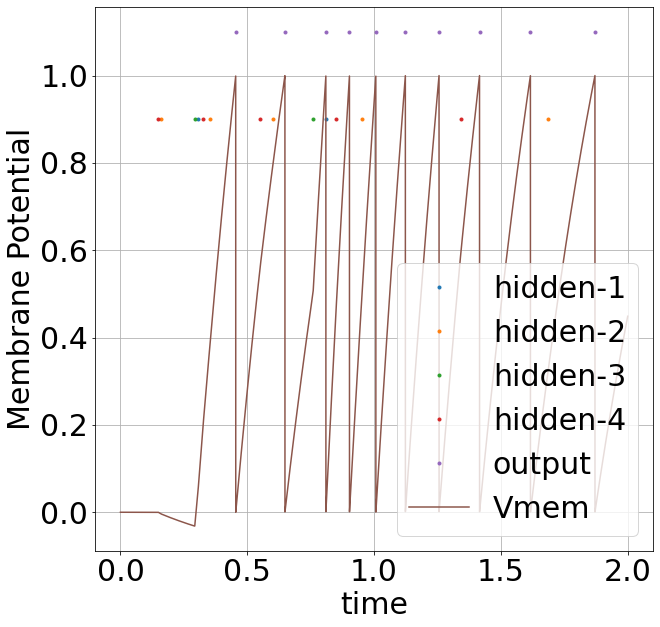

In [186]:
#================= test evolve: more than one input neuron ================

out_idx = 0

# number of neurons on the previous layer
N=4

# total simulation time
t_sim=2

# produce firing times for neurons
#spikes=np.sort(t_sim*np.random.rand(N,F),axis=1)
# spikes = np.array([[9.36482925],
#        [14.32551153],
#        [15.67448847],
#        [ 20.63517075]])
spikes = hidden_out

# plot the spikes
#TSEvent(times=spikes.T, t_start=0, t_stop=t_sim).plot()

# produce the corresponding weights
# make sure we have both positive and negative weights
w=nnet.weights[-1][out_idx]
#w=np.random.randn(N)
#w=[0.5, -0.2]

        
#evolve(spikes, w, A=0, B=0, alpha=2,beta=1, theta=1):
A=0; alpha=ALPHA;
B=0; beta=BETA;

theta=THETA

# obtain the firing times
fire_time=final_out[out_idx]

# plot the results for sanity check
t=np.linspace(0, t_sim, 10000)
v_pot=np.zeros_like(t)

# add the effect of input firing times
for i,spk in enumerate(spikes):
    for f in spk:
        v_pot+=w[i]*(np.exp(-alpha*(t-f))-np.exp(-beta*(t-f)))/(beta-alpha)*np.heaviside(t-f,0)

# add the effect of potential reset
for f in fire_time:
    v_pot-=theta*np.exp(-beta*(t-f))*np.heaviside(t-f,0)

# plot the membrane potential
plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 30})

for spk in spikes:
    plt.plot(spk,0.9*np.ones_like(spk), '.')
    
plt.plot(fire_time,1.1*np.ones_like(fire_time), '.')
plt.plot(t,v_pot)
plt.grid(True)
plt.legend([*([f'hidden-{i}' for i in range(1,N+1)]), 'output', 'Vmem'], loc='lower right')
plt.xlabel('time')
plt.ylabel('Membrane Potential')
    
plt.savefig('xor_out_0.png', dpi=200)

